In [2]:
import time
import torch
import torchvision
import cv2
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Augmentations

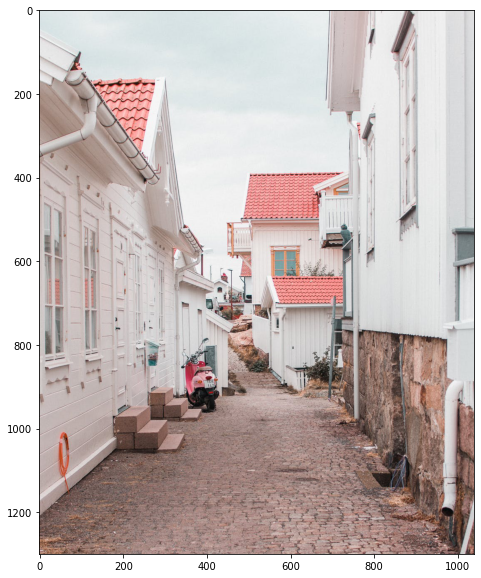

(1040, 1300)


In [9]:
# First we'll just visualize the image

image = Image.open("/content/gdrive/MyDrive/Intro_to_Deep_Learning/Recitation_3_4/street.jpg")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()
print(image.size)

Here is a list of (some) the augmentations available in PyTorch

Note: Some of them (like RandomErase and Normalize) only work on Tensors, so be careful where you stack them in the pre-processing pipeline (more on this later); ie only after ToTensor()

```
transforms.Resize((256, 256))
transforms.RandomCrop(224)
transforms.RandomHorizontalFlip(p=0.5)
transforms.RandomVerticalFlip(p=0.5)
transforms.ColorJitter()
transforms.RandomRotation(degrees=5)
transforms.RandomPerspective()
transforms.GaussianBlur(kernel_size=3)
transforms.RandomSolarize(threshold=0.1)
transforms.ToTensor()
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transforms.RandomErasing()
```


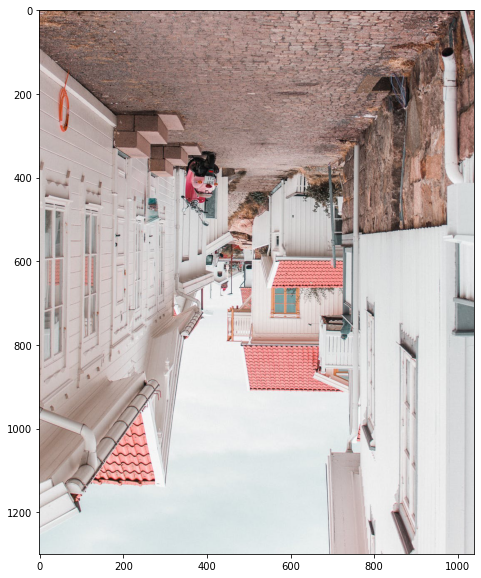

In [7]:
# A simple VerticalFlip with probability of 0.75 (meaning out of 100 images, 75 will be flipped vertically). 
# The default number is 0.5.

sample = transforms.RandomVerticalFlip(p=0.75)(image)
plt.figure(figsize=(10, 10))
plt.imshow(sample)
plt.show()

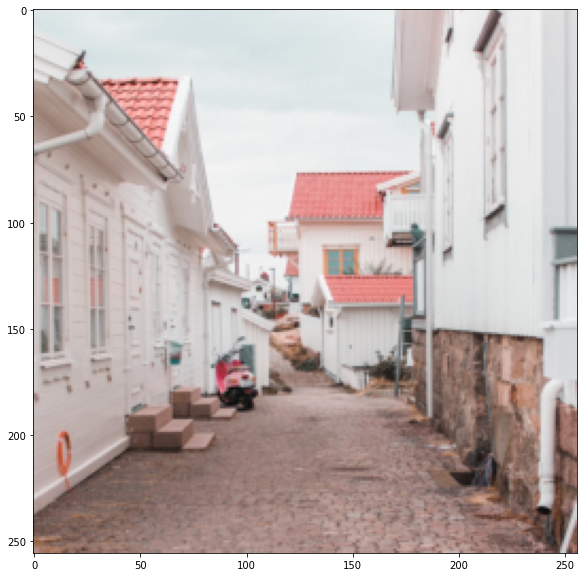

In [6]:
# Resizing. The original image was very large (1040, 1300)
# Note the axis in PIL are flipped! So for us this is 1300x1040
# We'll resize it so 256x256
# See the aspect ratio got a bit distorted

sample = transforms.Resize((256, 256))(image)
plt.figure(figsize=(10, 10))
plt.imshow(sample)
plt.show()

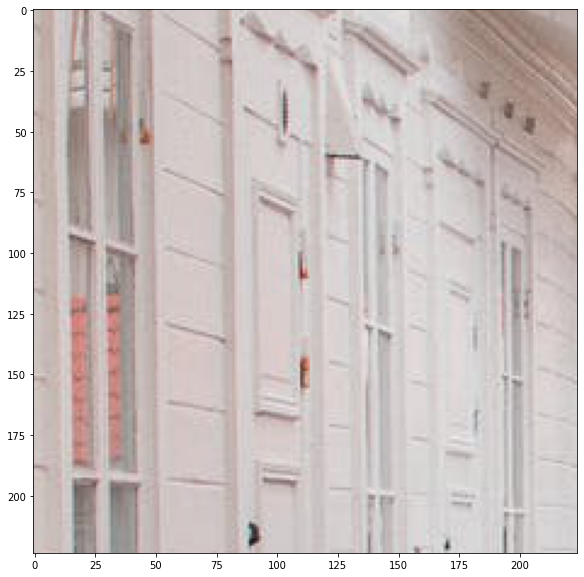

In [10]:
# Now we want to crop out a piece of size 224x224 because this is the standard for ImageNet
# Note we cropped out a piece from the original image - so it's only a tiny fraction!

sample = transforms.RandomCrop(224)(image)
plt.figure(figsize=(10, 10))
plt.imshow(sample)
plt.show()

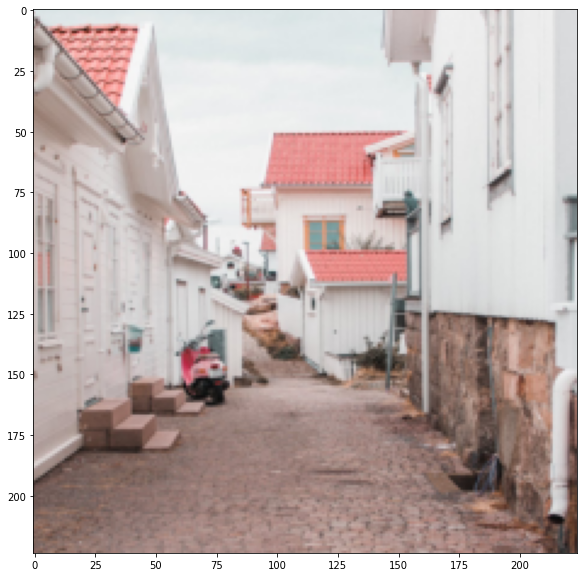

In [11]:
# So what do we do if we want to concat transforms? 
# For example we want to first resize, then crop so we get an image of size 224x224 of the original image.
# We can nest the functions one inside the other like so (it'll get ugly if we add more transforms):

sample = transforms.RandomCrop(224)(transforms.Resize((256, 256))(image))
plt.figure(figsize=(10, 10))
plt.imshow(sample)
plt.show()

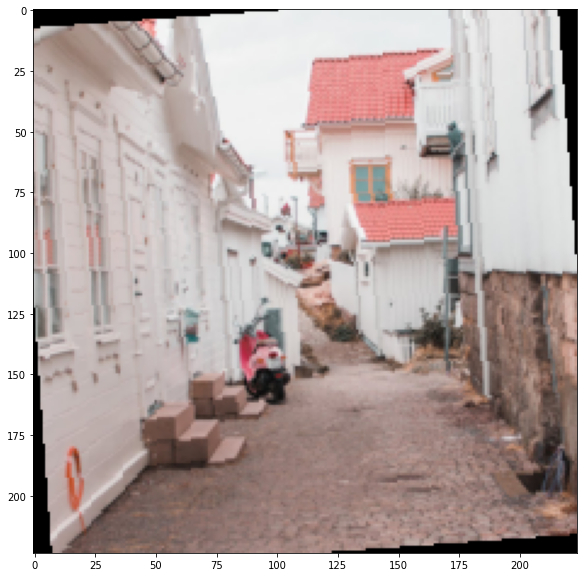

In [13]:
# The solution is to use transforms.Compose([]), making everything readable!

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomRotation(degrees=5),
    transforms.RandomPerspective(),
    transforms.GaussianBlur(kernel_size=3)
])

sample = preprocess(image)
plt.figure(figsize=(10, 10))
plt.imshow(sample)
plt.show()

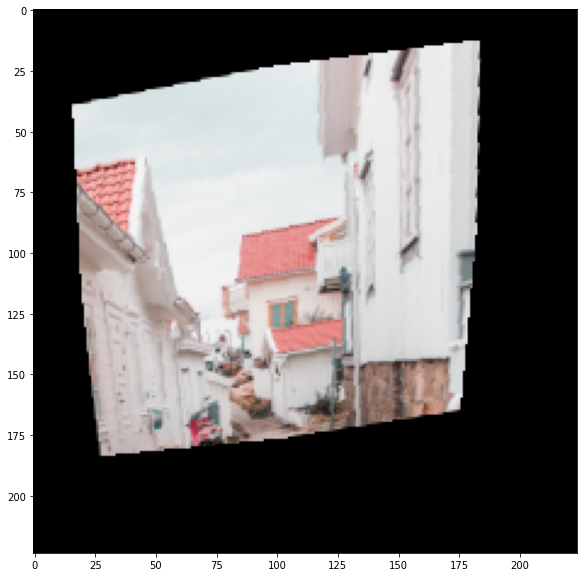

torch.Size([3, 224, 224])


In [20]:
# Now in a real pipeline, we'll always need to cast the image into a torch.Tensor like so:

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomRotation(degrees=5),
    transforms.RandomPerspective(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

sample = preprocess(image)
plt.figure(figsize=(10, 10))
plt.imshow(transforms.ToPILImage()(sample))
plt.show()
print(sample.shape)

# Three things to note:
# 1. We can't visualize the image with matplotlib since it's a torch object, so I used transforms.ToPILImage() (It's not part of the pipeline!!!! Only for visualization)
# 2. The funky colors are because of the normlization (comment it out and see for yourselves)
# 3. If you use a different library, you might need to divide the image by 255 (PIL loads them in [0,1], others [0,255])

In [21]:
# Okay now let's build a small dataset like we learned in Recitation 3

class BasicDataset(Dataset):
    def __init__(self, file_paths, labels, transforms=None):
        """
        file_paths:  List[str]
        labels:      List[int]
        transforms:  torch transforms.Compose
        """
        assert len(file_paths) == len(labels), "Number of images and labels given don't match"
        self.file_paths = file_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        # Read an image with PIL
        image = Image.open(file_path)

        # If we have transforms, apply them to the image
        if self.transforms:
            image = self.transforms(image)

        return image, label

In [22]:
# Then we'll define the preprocessing we want to do

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomRotation(degrees=5),
    transforms.RandomPerspective(),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

# Then the dataset
my_dataset = BasicDataset(
    file_paths=["/content/gdrive/MyDrive/Intro_to_Deep_Learning/Recitation_3_4/street.jpg"],
    labels=[1],
    transforms=preprocess,
)

# Finally the dataloader
dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=1, num_workers=1)


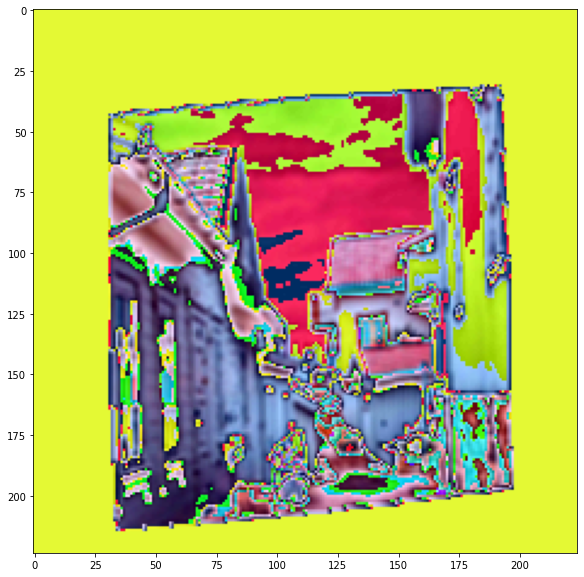


Image shape:  torch.Size([3, 224, 224])
Label:  tensor([1])


In [28]:
# Now lets iterate over the dataloader like in a training loop, but since we don't have a model we'll just visualie the image:
for input,label in dataloader:
    plt.figure(figsize=(10, 10))
    plt.imshow(transforms.ToPILImage()(sample))
    plt.show()
    print()
    print("Image shape: ", sample.shape)
    print("Label: ", label)

# Dropout

In [5]:
# Now we'll show a short example of how to use dropout in a network

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),      
      nn.Dropout(p=0.5),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.Dropout(p=0.5),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [7]:
net = MLP().train()
x = torch.ones(size=(1,1,28,28))
y = net(x)
print(y)
y = net(x)
print(y)

# Note: see how the output changes

tensor([[ 0.2114, -0.4257,  0.3380,  0.0988,  0.0702, -0.0310, -0.0590,  0.2701,
          0.1690,  0.1647]], grad_fn=<AddmmBackward>)
tensor([[ 0.1062, -0.0488,  0.4110,  0.1300,  0.1615, -0.1279,  0.1640, -0.0973,
          0.2233, -0.1718]], grad_fn=<AddmmBackward>)


In [8]:
net.eval()
y = net(x)
print(y)
y = net(x)
print(y)

# Note: see how the output doesn't change

tensor([[ 0.0158, -0.1650,  0.1555,  0.0526,  0.0033, -0.1242,  0.0291,  0.0381,
          0.1440, -0.0436]], grad_fn=<AddmmBackward>)
tensor([[ 0.0158, -0.1650,  0.1555,  0.0526,  0.0033, -0.1242,  0.0291,  0.0381,
          0.1440, -0.0436]], grad_fn=<AddmmBackward>)


# BatchNorm

In [17]:
# BatchNorm

class SimpleBN(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(3, 2, 1),
      nn.BatchNorm2d(num_features=2),
      nn.ReLU(),
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x) 

In [18]:
net = SimpleBN().train()
x = torch.ones(size=(1,3,10,10))
y = net(x)
print(y)

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],

In [19]:
net.eval()
y = net(x)
print(y)

# Note: see how the output changes relative to the train() model - the behaviour of the BN layer is different (think how?)

tensor([[[[0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078,
           0.9078, 0.9078],
          [0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078, 0.9078

# Weight Decay

In [ ]:
# Adding weight decay in torch is done with the **optimizer** and not via the loss!

optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)

# Good values to try are 1e-4 to 1e-5 (rule of thumb - these numbers could be vastly different depending on your dataset, model and loss!)